In [1]:
%matplotlib inline

import os
import sys
sys.path.append('../')
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

import glob
import random
import cv2
import numpy as np
import networkx as nx
import open3d as o3d
import torch
import torch.nn.functional as F
from datetime import datetime

import roma
import kornia
import utils.colmap as colmap_utils


from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from matplotlib import pyplot as plt

from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images_ratio, load_and_preprocess_images_square
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

from utils.umeyama import umeyama
from utils.metric_torch import evaluate_auc, evaluate_pcd

torch._dynamo.config.accumulated_cache_size_limit = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def run_VGGT(images, device, dtype):
    # images: [B, 3, H, W]

    # Run VGGT for camera and depth estimation
    model = VGGT()
    _URL = "https://huggingface.co/facebook/VGGT-1B/resolve/main/model.pt"
    model.load_state_dict(torch.hub.load_state_dict_from_url(_URL))
    model.eval()
    model = model.to(device).to(dtype)
    print(f"Model loaded")

    with torch.no_grad():
        predictions = model(images.to(device, dtype), verbose=True)
        extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions['pose_enc'], images.shape[-2:])
        extrinsic = extrinsic.squeeze(0).cpu().numpy()
        intrinsic = intrinsic.squeeze(0).cpu().numpy()
        depth_map = predictions['depth'].squeeze(0).cpu().numpy()
        depth_conf = predictions['depth_conf'].squeeze(0).cpu().numpy()
    
    return extrinsic, intrinsic, depth_map, depth_conf

Processing scene: bicycle
Processing scene: bonsai
Processing scene: counter
Processing scene: flowers
Processing scene: garden
Processing scene: kitchen
Processing scene: room
Processing scene: stump
Processing scene: treehill


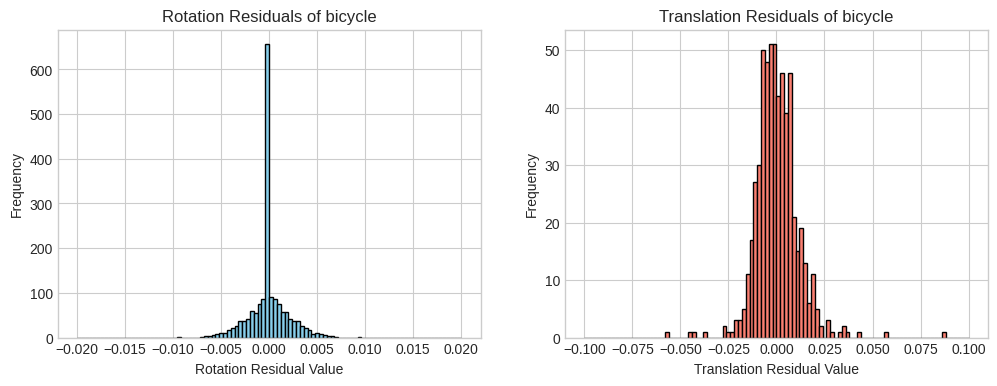

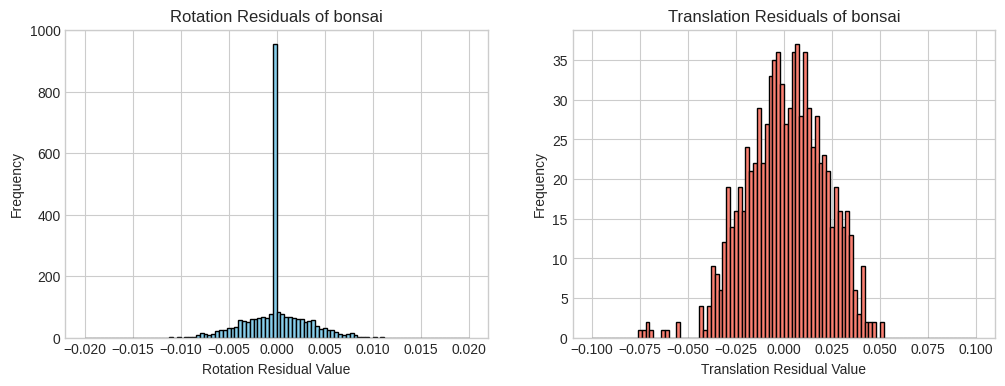

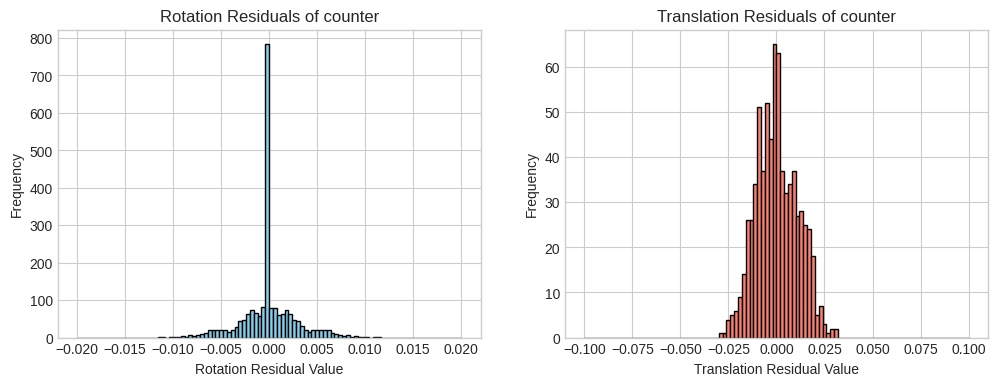

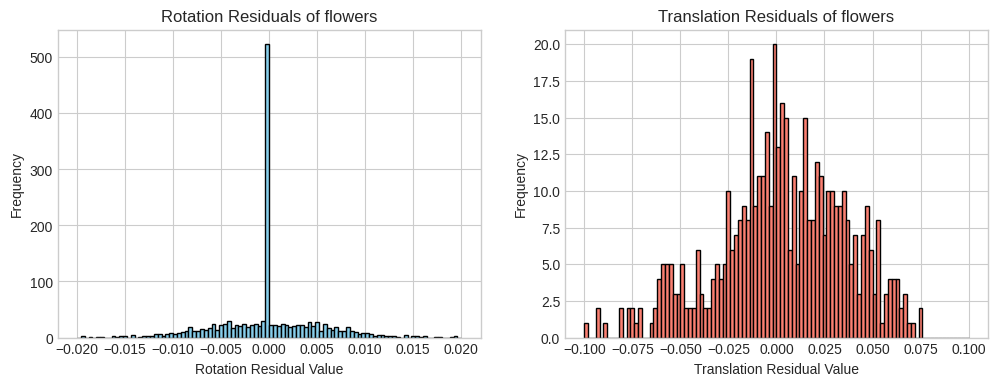

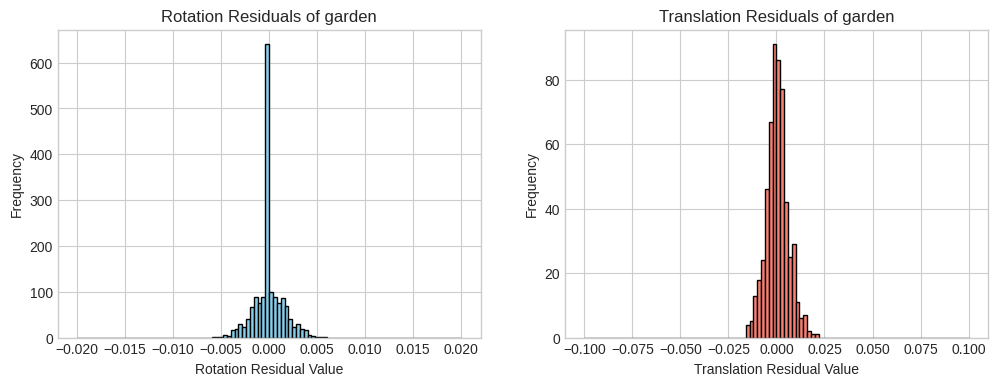

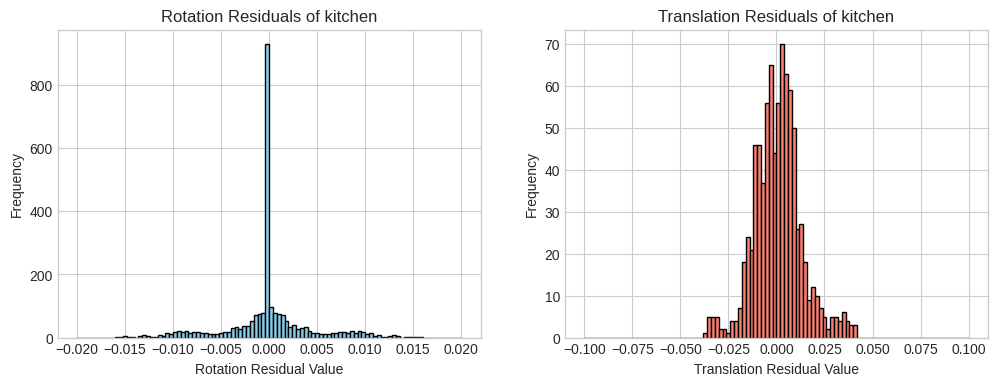

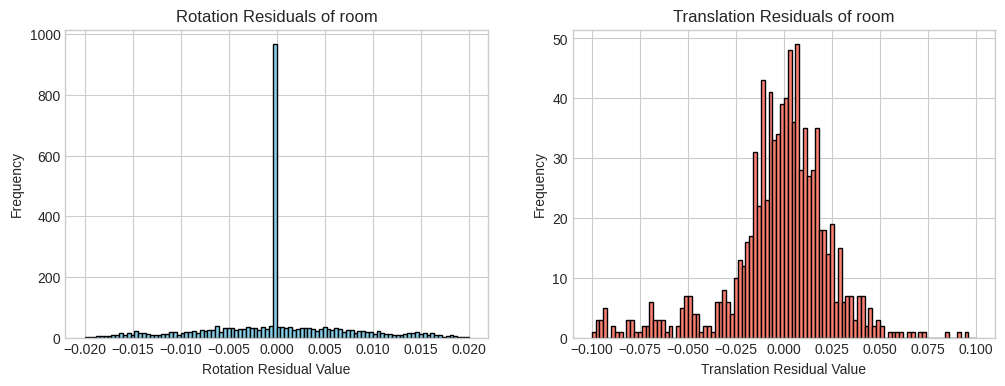

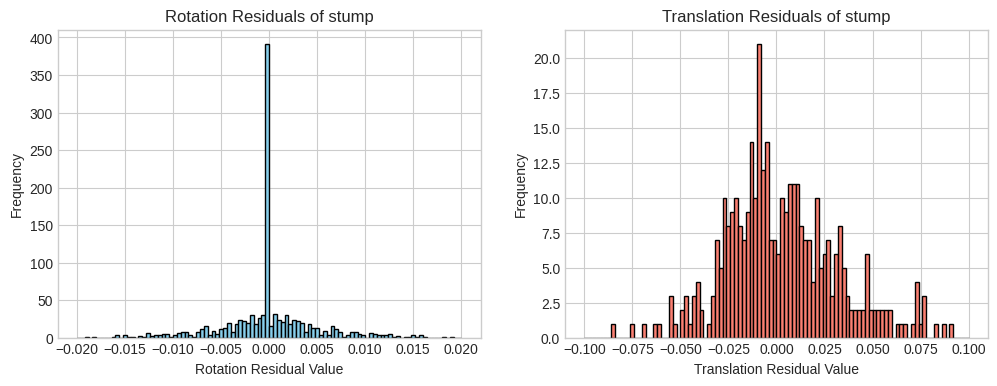

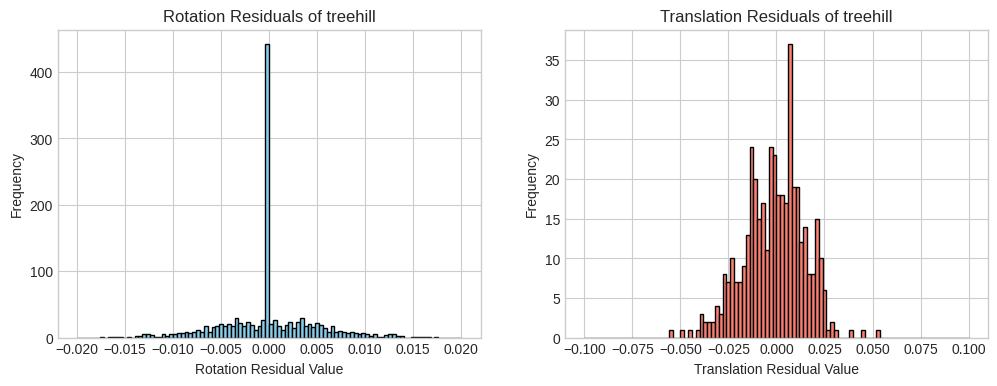

In [4]:
# Get image paths and preprocess them
data_dir_gt = "../data/MipNeRF360"
data_dir_pred = "../data/MipNeRF360_vggt_opt_gt_align"
mode="DEBUG"  # "EVAL" or "DEBUG"
# f.write(f"Relative Rotation Error (degrees): {auc_results['rel_rangle_deg']}\n")
# f.write(f"Relative Translation Error (degrees): {auc_results['rel_tangle_deg']}\n")
# f.write(f"AUC at 30 degrees: {auc_results['Auc_30']}\n")

results_rel_rangle_deg = []
results_rel_tangle_deg = []
results_Auc_30 = []
scenes = sorted(os.listdir(data_dir_pred))
for scene in scenes:
    if os.path.isdir(os.path.join(data_dir_gt, scene)):
        print(f"Processing scene: {scene}")
        sparse_dir_gt = os.path.join(data_dir_gt, scene, "sparse", "0")
        images_dir = os.path.join(data_dir_gt, scene, "images")

        cameras_gt = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_gt, "cameras.bin"))
        images_gt = colmap_utils.read_images_binary(os.path.join(sparse_dir_gt, "images.bin"))
        pcd_gt = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_gt, "points3D.bin"))

        sparse_dir_pred = os.path.join(data_dir_pred, scene, "sparse", "0")
        cameras_pred = colmap_utils.read_cameras_binary(os.path.join(sparse_dir_pred, "cameras.bin"))
        images_pred = colmap_utils.read_images_binary(os.path.join(sparse_dir_pred, "images.bin"))
        images_pred_updated = {id: images_pred[id] for id in list(images_gt.keys())}
        pcd_pred = colmap_utils.read_points3D_binary(os.path.join(sparse_dir_pred, "points3D.bin"))

        # print(f"GT's intrinsics: {cameras_gt[1].params}")
        # print(f"Pred's intrinsics: {cameras_pred[1].params}")
        # diff = cameras_gt[1].params - cameras_pred[1].params
        # print("Intrinsic Difference", np.linalg.norm(diff[:2] / cameras_gt[1].params[2:]))

        translation_gt = torch.tensor([image.tvec for image in images_gt.values()], device=device)
        rotation_gt = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_gt.values()], device=device)
        gt_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt), 1, 1)
        gt_se3[:, :3, :3] = rotation_gt
        gt_se3[:, 3, :3] = translation_gt

        translation_pred = torch.tensor([image.tvec for image in images_pred_updated.values()], device=device)
        rotation_pred = torch.tensor([colmap_utils.qvec2rotmat(image.qvec) for image in images_pred_updated.values()], device=device)
        pred_se3 = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_pred_updated), 1, 1)
        pred_se3[:, :3, :3] = rotation_pred
        pred_se3[:, 3, :3] = translation_pred

        if mode == "EVAL":
            auc_results, _, c, R, t = evaluate_auc(pred_se3, gt_se3, device, return_aligned=True)

            for point_id, point in pcd_pred.items():
                point.xyz = (c * R @ point.xyz + t.squeeze())
            
            pcd_xyz_gt = np.stack([point.xyz for point in pcd_gt.values()], axis=0)
            pcd_rgb_gt = np.stack([point.rgb for point in pcd_gt.values()], axis=0)
            pcd_xyz_pred = np.stack([point.xyz for point in pcd_pred.values()], axis=0)
            pcd_rgb_pred = np.stack([point.rgb for point in pcd_pred.values()], axis=0)

            mask = ((pcd_xyz_pred < pcd_xyz_gt.max(axis=0)) & (pcd_xyz_pred > pcd_xyz_gt.min(axis=0))).all(axis=1)
            pcd_xyz_pred = pcd_xyz_pred[mask]
            pcd_rgb_pred = pcd_rgb_pred[mask]
            
            pcd_src = o3d.geometry.PointCloud()
            pcd_src.points = o3d.utility.Vector3dVector(pcd_xyz_gt)
            pcd_src.colors = o3d.utility.Vector3dVector(pcd_rgb_gt)

            pcd_tgt = o3d.geometry.PointCloud()
            pcd_tgt.points = o3d.utility.Vector3dVector(pcd_xyz_pred)
            pcd_tgt.colors = o3d.utility.Vector3dVector(pcd_rgb_pred)

            trans_init, threshold  = np.eye(4), 0.1
            reg_p2p = o3d.pipelines.registration.registration_icp(
                pcd_tgt,
                pcd_src,
                threshold,
                trans_init,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            )
            pcd_tgt.transform(reg_p2p.transformation)

            completeness = pcd_src.compute_point_cloud_distance(pcd_tgt)
            accuracy = pcd_tgt.compute_point_cloud_distance(pcd_src)

            accuracy_mean = np.mean(accuracy)  # to be written to txt file
            completeness_mean = np.mean(completeness)  # to be written to txt file
            chamfer_distance = np.mean(np.concatenate([accuracy, completeness]))  # to be written to txt file

            results_Auc_30.append(auc_results['Auc_30'])
            results_rel_rangle_deg.append(auc_results['rel_rangle_deg'].item())
            results_rel_tangle_deg.append(auc_results['rel_tangle_deg'].item())
        elif mode == "DEBUG":
            c2w_gt = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_gt), 1, 1)
            c2w_gt[:, :3, :3] = rotation_gt.transpose(1, 2)
            c2w_gt[:, :3, 3] = - (rotation_gt.transpose(1, 2) @ translation_gt[..., None]).squeeze(-1)

            c2w_pred_inv = torch.eye(4, device=device).unsqueeze(0).repeat(len(images_pred_updated), 1, 1)
            c2w_pred_inv[:, :3, :3] = rotation_pred
            c2w_pred_inv[:, :3, 3] = translation_pred

            # c2w_gt = torch.matmul(c2w_pred, tgt_transform)
            tgt_transform = torch.matmul(c2w_pred_inv, c2w_gt)

            diff = (tgt_transform - torch.eye(4, device=device).unsqueeze(0)).cpu().numpy()
            plt.style.use("seaborn-v0_8-whitegrid")
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.hist(diff[:, :3, :3].reshape(-1), bins=100, range=(-0.02, 0.02), color='skyblue', edgecolor='black')
            plt.title(f"Rotation Residuals of {scene}")
            plt.xlabel("Rotation Residual Value")
            plt.ylabel("Frequency")

            plt.subplot(1, 2, 2)
            plt.hist(diff[:, :3, 3].reshape(-1), bins=100, range=(-0.1, 0.1), color='salmon', edgecolor='black')
            plt.title(f"Translation Residuals of {scene}")
            plt.xlabel("Translation Residual Value")
            plt.ylabel("Frequency")

        # camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)

        # print(f"Range of GT camera centers: {camera_centers_gt.max(0) - camera_centers_gt.min(0)}")

In [5]:
print(f"Average Relative Rotation Error (degrees): {np.mean(results_rel_rangle_deg)}")
print(f"Average Relative Translation Error (degrees): {np.mean(results_rel_tangle_deg)}")
print(f"Average AUC at 30 degrees: {np.mean(results_Auc_30)}")

Average Relative Rotation Error (degrees): 0.4500442147254944
Average Relative Translation Error (degrees): 0.36833086609840393
Average AUC at 30 degrees: 0.9965130023640664


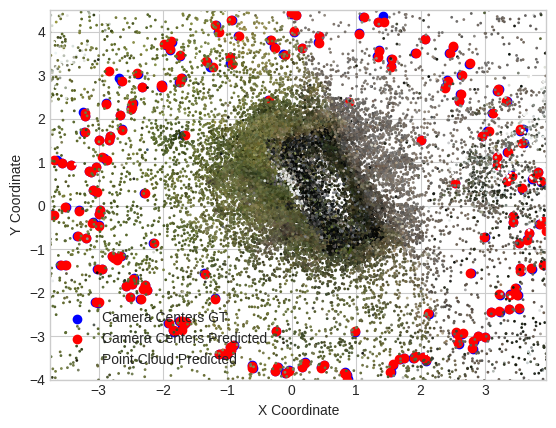

In [11]:
camera_centers_gt = - (gt_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ gt_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
camera_centers_pred = - (pred_se3[:, :3, :3].cpu().numpy().transpose(0, 2, 1) @ pred_se3[:, 3, :3][..., None].cpu().numpy()).squeeze(-1)
c, R, t = umeyama(camera_centers_gt.T, camera_centers_pred.T)
camera_centers_gt_aligned = (c * (R @ camera_centers_gt.T) + t).T
variance = np.var(camera_centers_pred, axis=0)
ground_plane_indices = np.argsort(variance)[1:]
pcd_interval = 10

if pcd_rgb_pred.max() > 1.0:
    pcd_rgb_pred = pcd_rgb_pred / 255.0

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(camera_centers_gt_aligned[:, ground_plane_indices[0]], camera_centers_gt_aligned[:, ground_plane_indices[1]], c='blue', label='Camera Centers GT')
plt.scatter(camera_centers_pred[:, ground_plane_indices[0]], camera_centers_pred[:, ground_plane_indices[1]], c='red', label='Camera Centers Predicted')
plt.scatter(pcd_xyz_pred[::pcd_interval, ground_plane_indices[0]], pcd_xyz_pred[::pcd_interval, ground_plane_indices[1]], c=pcd_rgb_pred[::pcd_interval], s=1, label='Point Cloud Predicted')
plt.xlim(camera_centers_pred[:, ground_plane_indices[0]].min(), camera_centers_pred[:, ground_plane_indices[0]].max())
plt.ylim(camera_centers_pred[:, ground_plane_indices[1]].min(), camera_centers_pred[:, ground_plane_indices[1]].max())
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()